In [1]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import numpy as np
import random
from collections import deque

# Nastavení proměnných

In [2]:
# rozmery prostoru
WORLD_HEIGHT = 500
WORLD_WIDTH = 500

# rozmery vykreslovaneho grafu
FIG_HEIGHT = 15
FIG_WIDTH = 15

In [3]:
# pocatecni souradnice robota
robot_x = 450
robot_y = 450
robot = (robot_x, robot_y)

# souradnice cile
target_x = 50
target_y = 50
target = (target_x, target_y)

In [4]:
# souradnice mnohouhelnikovych prekazek
polygons = [
    [(100,100),(200,70),(250,90),(220,120)],
    [(50,150),(110,150),(110,400),(60,400)],
    [(130,150),(150,150),(150,200),(130,200)],
    [(150,30),(150,20),(450,20),(450,80),(300,85)],
    [(300,300),(400,300),(350,450)],
    [(200,160),(450,150),(470,280),(190,270)],
    [(120,490),(120,270),(270,300),(190,470)]
]

# Vytvoření světa

In [5]:
# fce pro vztvoreni shapely objektu ze zadanych mnohouhelniku
def return_Polygons(polygons):
    Polygons = []
    for pol in polygons:
        Polygons.append(Polygon(pol))
    return Polygons

In [6]:
# vypresleni prostoru
def show_world(polygons, robot, target, path=None):
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax.set_axis_off()
    
    # show polygons
    for polygon in polygons:
        ax.add_patch(patches.Polygon(np.array(polygon) / WORLD_HEIGHT, True, color='c'))
        
    # show solution path
    if path:
        path_lines = [path[k:k+2] for k in range(len(path) - 1)]
        for line in path_lines:
            ax.add_line(lines.Line2D((line[0][0] / WORLD_WIDTH, line[1][0] / WORLD_HEIGHT),
                                 (line[0][1] / WORLD_WIDTH, line[1][1] / WORLD_HEIGHT), color='r'))
    # show robot
    ax.add_patch(patches.Wedge(center = (robot[0] / WORLD_WIDTH, robot[1] / WORLD_HEIGHT), r = 0.02, 
                           theta1 = 220, theta2 = 160, color='tab:orange')) 
    
    # show target
    ax.add_patch(patches.Circle((target[0] / WORLD_WIDTH, target[1] / WORLD_HEIGHT), 0.02, color='m'))
    
    # show border
    ax.add_patch(patches.Rectangle((0.001, 0.001), 0.99, 0.99, fill=False))

# Vytvoření diskrétního stavového prostoru

In [7]:
# fce pro detekci toho zda dana hrana krizi nejaky mnohouhelnik
def check_collisions(edge, Polygons):
    Edge = LineString(edge)
    for polygon in Polygons:
        # ma hrana s mnohouhelnikem nejaky spolecny prostor?
        if polygon.intersects(Edge):
            pol_coor = list(polygon.exterior.coords)
            # hrana se nedotyka pouze vrcholu mnohouhelniku
            if not Edge.touches(polygon):
                return False
    return True

In [8]:
# vytvoreni diskretniho stavoveho prostoru
def make_descrete_statespace(Polygons, polygons, robot, target):
    # stavy
    vertices = []
    # akce
    edges = []

    # pridani do stavu vrcholy mnohouhelniku
    for polygon in polygons:
        for vertice in polygon:
            vertices.append(vertice)

    # pridani povolenych hran/akci
    for vertice in vertices:
        for neigh in vertices:
            if vertice == neigh:
                continue
            edge = [vertice, neigh]
            if check_collisions(edge, Polygons):
                edges.append(edge)
        if check_collisions([(robot[0], robot[1]), vertice], Polygons):
            edges.append([(robot[0], robot[1]), vertice])
        if check_collisions([vertice, (target[0], target[1])], Polygons):
            edges.append([vertice, (target[0], target[1])])
            
    # robot se muze dostat primo do cile
    if check_collisions([(robot[0], robot[1]), (target[0], target[1])], Polygons):
        edges.append([(robot[0], robot[1]), (target[0], target[1])])
    return vertices, edges

In [9]:
# vykresleni stavoveho prostoru
def show_statespace(vertices, edges, polygons, robot, target):
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax.set_axis_off()
    
    # show robot
    ax.add_patch(patches.Wedge(center = (robot[0] / WORLD_WIDTH, robot[1] / WORLD_HEIGHT), r = 0.02, 
                           theta1 = 220, theta2 = 160, color='tab:orange')) 
    
    # show target
    ax.add_patch(patches.Circle((target[0] / WORLD_WIDTH, target[1] / WORLD_HEIGHT), 0.02, color='m'))
    
    # show border
    ax.add_patch(patches.Rectangle((0.001, 0.001), 0.99, 0.99, fill=False))

    # show polygons
    for polygon in polygons:
        ax.add_patch(patches.Polygon(np.array(polygon) / WORLD_HEIGHT, True, color='c', alpha=0.1))

    # show vertices
    for vertice in vertices:
        ax.add_patch(patches.Circle((vertice[0] / WORLD_WIDTH, vertice[1] / WORLD_HEIGHT), 0.01, color='y'))

    # show edges
    for edge in edges:
        ax.add_line(lines.Line2D([edge[0][0] / WORLD_WIDTH, edge[1][0] / WORLD_WIDTH]
                                 ,[edge[0][1] / WORLD_WIDTH, edge[1][1] / WORLD_HEIGHT], color='k'))

# Hledání nejkratší cesty

In [10]:
# eukleidovska heuristika
def heuristics(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

def reconstructed_path(prev, x):
    path = []
    while x in prev:
        path.append(x)
        x = prev[x]
    path.append(x)
    return path

# vsechny dostupne akce z daneho vrcholu
def neighbours(x, edges):
    neighbours = []
    for edge in edges:
        if x == edge[0]:
            neighbours.append(edge[1])
    return neighbours

In [11]:
def A_star(start, end):
    opened = []
    dist = {}
    prev = {}
    priority = {}
    closed = set()

    opened.append(start)
    priority[start] = heuristics(start, end)
    dist[start] = 0
    while len(opened):
        min_node = opened[0]
        for node in opened:
            if priority[node] < priority[min_node]:
                min_node = node
        x = min_node
        if x == end:
            return reconstructed_path(prev, x)
        for y in neighbours(x, edges):
            if y not in closed:
                d = dist[x] + 1
                if y not in opened or d < dist[y]:
                    dist[y] = d
                    prev[y] = x
                    if y not in opened:
                        opened.append(y)
                        priority[y] = d + heuristics(y, end)
                    else:
                        priority[y] = d + heuristics(y, end)

        opened.remove(x)
        del priority[x]
        closed.add(x)
    return [start, end]

# Ukázka
#### Vytvořila jsem ukázkový prostor. Prostor jsem pro ukázku omezila na čtvercový prostor o rozměrech 500 x 500. 
#### Robot je značen oranžově, cíl je značen růžově.

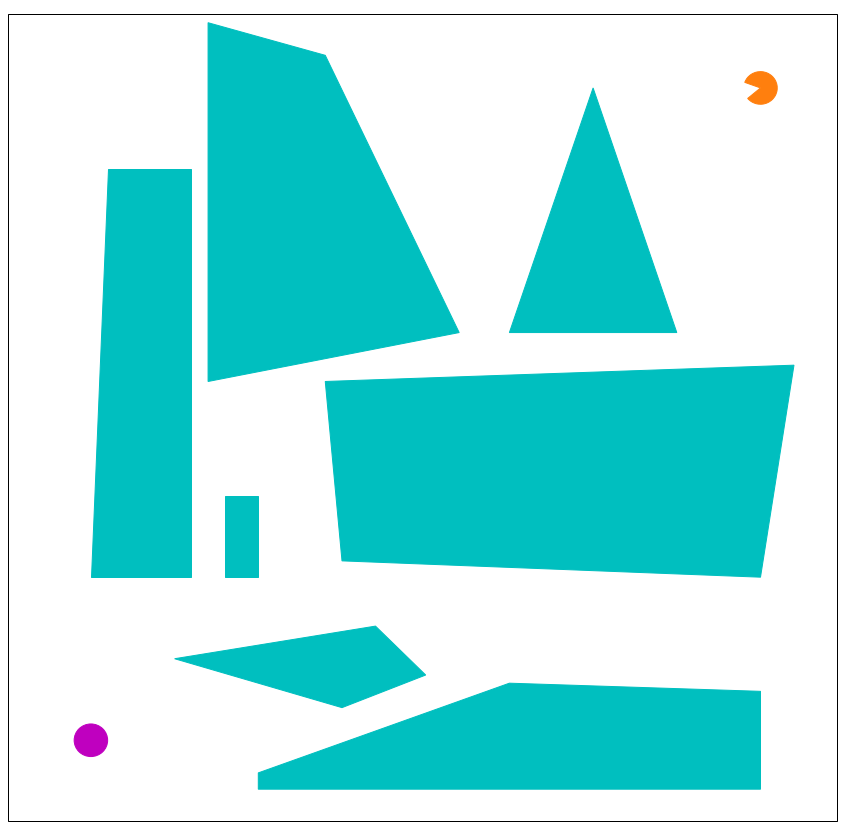

In [12]:
Polygons = return_Polygons(polygons)
show_world(polygons, robot, target)

#### Ukázka vytvořeného stavového prostoru, světle modře jsem pro lepší orientaci vyznačila původní mnohoúhelníky. Vykreslený graf zobrazuje všechny dostupné akce z daných stavů.

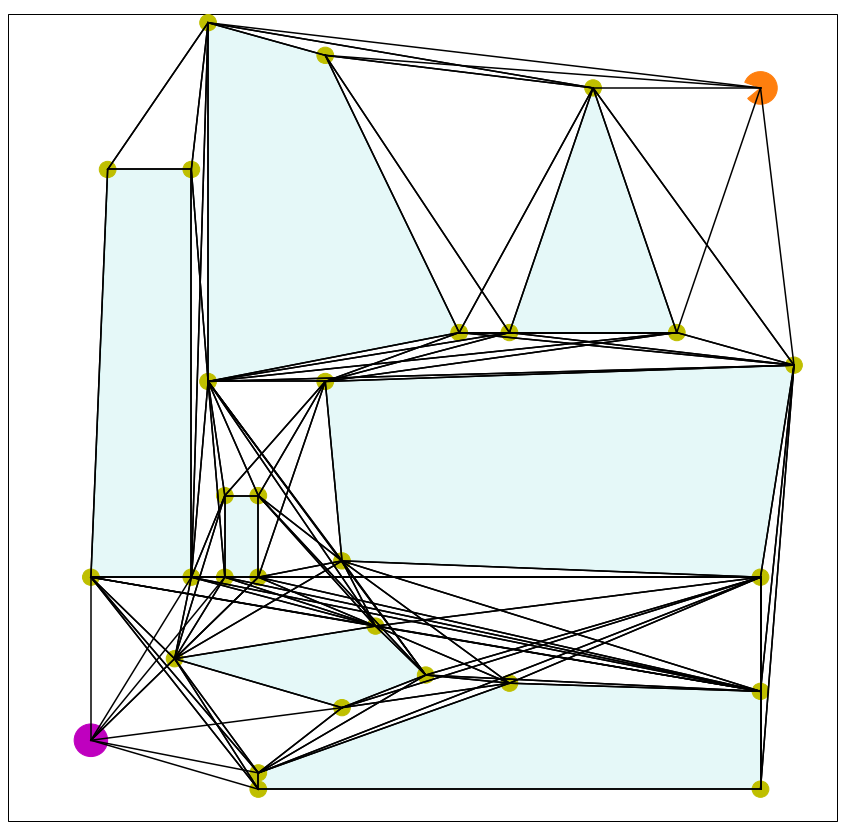

In [13]:
vertices, edges = make_descrete_statespace(Polygons, polygons, robot, target)
show_statespace(vertices, edges, polygons, robot, target)

#### Ukázka nalezení nejkratší cestu robota k cíly.

In [14]:
path = A_star(robot, target)
print(path)

[(50, 50), (110, 150), (120, 270), (400, 300), (450, 450)]


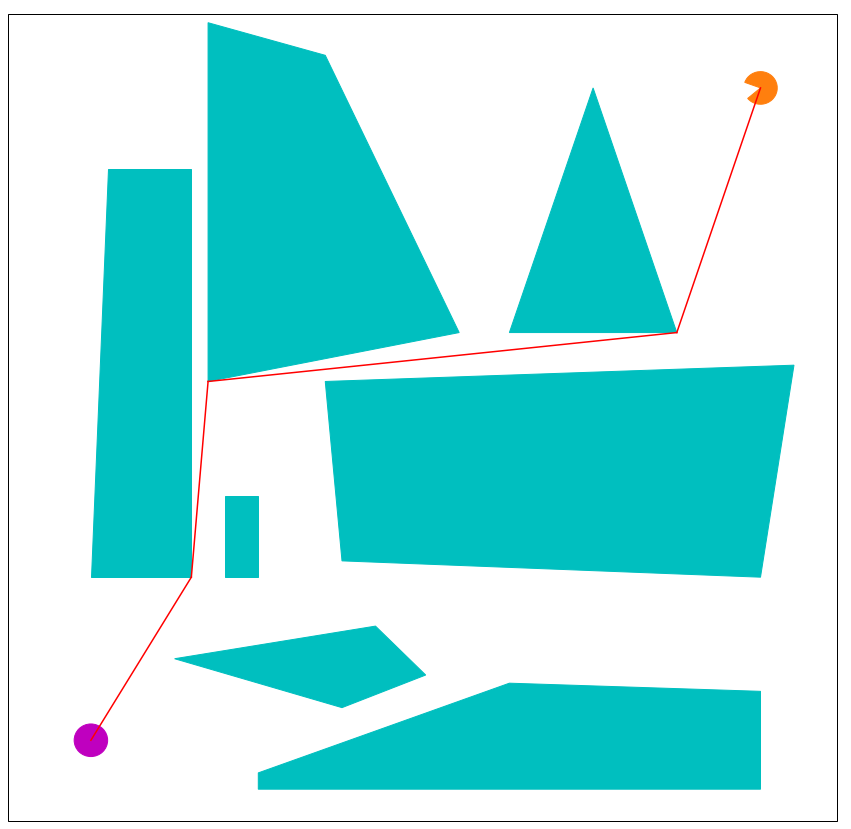

In [15]:
show_world(polygons, robot, target, path)